# Notebook 1: Introducción al aprendizaje por refuerzos

## FaMAF, 2019

### Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

#### Grupo 14

#### Alumnos: Martín Hunziker, Claudio Sarate



## The Cliff: 

![](images/cliffwalking.png)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* ^ - Arriba
* v - Abajo
* \> - Derecha
* < - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados 
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

Vemos los bloques básicos de nuestro agente

Primero, importamos:

In [1]:
import matplotlib.pyplot as plt
import itertools
import gym
import numpy as np
from agents.utils.plotting import plot_reward_per_episode, plot_steps_per_episode, plot_steps_per_episode_smooth, draw_value_matrix

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

In [2]:
def choose_action(state):
    """
    Chooses an action according to the learning previously performed 
    using an epsilon-greedy exploration policy
    """
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)

    if random_state.uniform() < epsilon:
        return random_state.choice(actions)  # a random action is selected

    count = q_values.count(max_q)

    # In case there're several state-action max values
    # we select a random one among them
    if count > 1:
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        i = q_values.index(max_q)

    return actions[i]


### Algoritmo SARSA

Definimos el esqueleto del método lear con el algoritmo SARSA

In [3]:
def learn(state, action, reward, next_state, next_action):
    """
    Performs a SARSA update for a given state transition
    """
    predict = q.get((state, action),0) 
    target = reward + gamma * q.get((next_state, next_action),0) 
    q[state, action] = predict+ alpha * (target - predict) 
    

Finalmente, definimos el método principal de iteraciones. 

In [4]:
def run():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        action = choose_action(state)
        
        while not done:

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(next_state)            

            episode_reward += reward

            if not done and t < 5000:  # if the algorithm does not converge, it stops after 2000 timesteps
                learn(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learn(state, action, reward, next_state, next_action)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [5]:
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 1
epsilon = 0.1
tau = 25

episodes_to_run = 2000

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

Ya instanciado, ejecutamos nuestro agente

In [6]:
avg_steps_per_episode, timesteps_ep, reward_ep = run()

### Análisis de la ejecución del agente

#### Análisis de convergencia

A diferencia de lo que sucede en el aprendizaje supervisado, en el aprendizaje por refuerzos el rendimiento se evalúa por una función específica que es la función de recompensa. En la práctica, la función de recompensa puede ser externa (y provista por el entorno) o bien puede ser una función creada por diseño (a modo de dirigir el agente hacia lo que por diseño se considera mejor, en nuestro ejemplo podría ser con una recompensa de $+1$ cada vez que el agente llega al estado objetivo). Esto se conoce como *reward shaping*, y hay que tener mucho cuidado con los posibles efectos secundarios de su uso.

Como el objetivo de RL es maximizar la recompensa obtenida, es posible utilizar la información sobre la obtención de la recompensas en cada time-step o episodio para evaluar el rendimiento parcial del agente (esto depende mucho de la particularidad de la distribución de la recompensa para el problema tratado).

Para analizar la ejecución del agente, vamos a ver cómo se desempeñó el mismo en dos curvas:

* Recompensa obtenida en cada episodio: nos dirá cuánta recompensa obtuvo el agente sumando cada una de recompensas individuales de cada episodio. Con esta medida podremos tener una noción de cómo se desempeñó esquivando el acantilado y llegando lo antes posible a la meta.

* Pasos transcurridos en cada episodio: indicará cuántos pasos le ha llevado al agente la ejecución del episodio.

Se estila suavizar ambas curvas para apreciar mejor su progresión (aunque a veces suele analizarse la curva de pasos por episodio sin suavizar).

Veamos recompensa por episodio (recordar que en este entorno cada paso otorga una recompensa de $-1$ excepto al caer al acantilado, donde la recompensa es de $-100$)

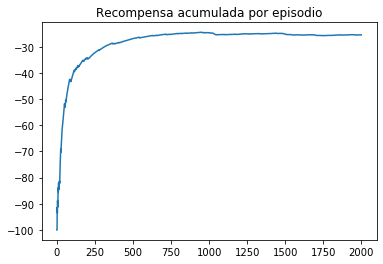

In [7]:
plot_reward_per_episode(reward_ep)

Veamos pasos por episodio

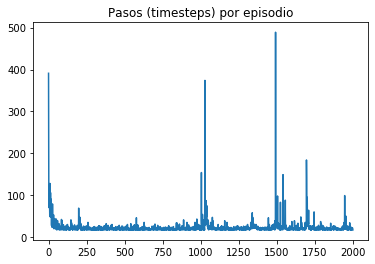

In [8]:
plot_steps_per_episode(timesteps_ep)

Suavizando...

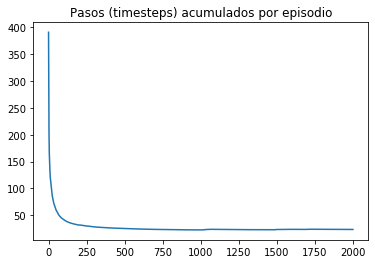

In [9]:
plot_steps_per_episode_smooth(timesteps_ep)

#### Análisis de matriz de acción-valor y política óptima

Siendo que este es un ejemplo tabular y de pocos estados / acciones, es posible realizar un análisis de convergencia desde otro punto de vista: desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente, (sería la acción que el agente ejecutaría en cada estado bajo una política *greedy*). Ambos nos brindarán información sobre la convergencia alcanzada por el agente.

Tener en cuenta que este análisis se hace principalmente con fines educativos, para entornos más complejos el mismo puede no ser factible. En tales casos, un análisis alternativo podría consistir en hacer que el agente ejecute su política para la que fue entrenado, para hacer una evaluación a partir del comportamiento del mismo (esto último sería el *test de la política*, frente al *entrenamiento de la política* previo).

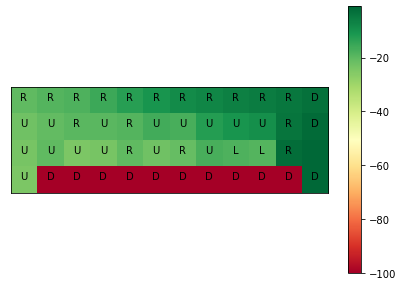


 Matriz de mejor acción-valor (en números): 

 [[ -20.14576413  -18.74323745  -17.94836622  -15.51293673  -12.76930709
   -10.56708351   -8.57327744   -7.22158389   -6.37053214   -5.52322137
    -4.34697675   -3.08670353]
 [ -22.43706292  -20.59562506  -19.27095528  -19.54827595  -18.5430603
   -16.29443127  -17.09120264  -12.28279812  -10.32208512   -9.4121788
    -3.99616835   -2.00000124]
 [ -23.75953398  -20.08707052  -24.33836794  -23.69672627  -20.03427147
   -22.39541537  -20.81126349  -16.85708246  -17.66582055  -18.55774698
    -2.53772953   -1.        ]
 [ -24.39230823 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [10]:
draw_value_matrix(q)

In [11]:
env.close()

### Algoritmo Q-Learning

In [12]:
def learnQ(state, action, reward, next_state):
    """
    Performs a q-learning update for a given state transition
    """
    predict = q.get((state, action),0) 
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)
                    
    target = reward + gamma * max_q
    q[state, action] = predict+ alpha * (target - predict) 



In [13]:
def runQ():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        
        while not done:

            action = choose_action(state)
    
            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            episode_reward += reward

            if not done and t < 3000:  # if the algorithm does not converge, it stops after 2000 timesteps
                learnQ(state, action, reward, next_state)
                state = next_state
                
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learnQ(state, action, reward, next_state)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

In [65]:
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 0.5
epsilon = 0.5
tau = 25

episodes_to_run = 1000

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [66]:
avg_steps_per_episode, timesteps_ep, reward_ep = runQ()

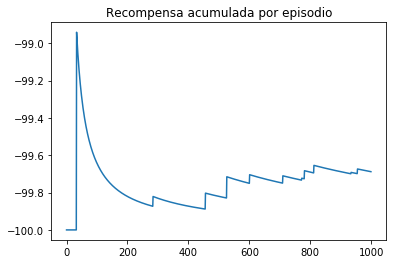

In [67]:
plot_reward_per_episode(reward_ep)

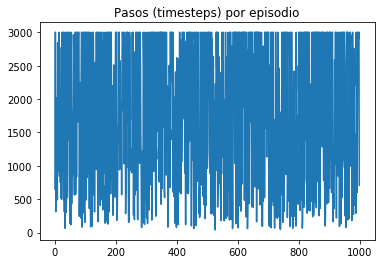

In [68]:
plot_steps_per_episode(timesteps_ep)

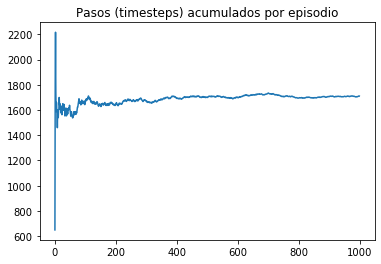

In [69]:
plot_steps_per_episode_smooth(timesteps_ep)

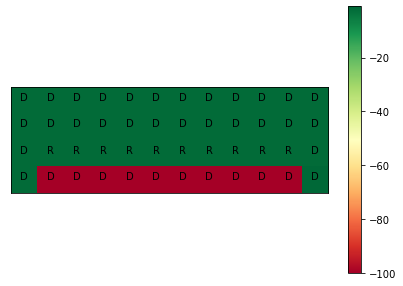


 Matriz de mejor acción-valor (en números): 

 [[  -2.   -2.   -2.   -2.   -2.   -2.   -2.   -2.   -2.   -2.   -2.   -2.]
 [  -2.   -2.   -2.   -2.   -2.   -2.   -2.   -2.   -2.   -2.   -2.   -2.]
 [  -2.   -2.   -2.   -2.   -2.   -2.   -2.   -2.   -2.   -2.   -2.   -2.]
 [  -2. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


In [70]:
draw_value_matrix(q)

Aparentemente los valores de la fila 3 columnas 1 y 2 están equivocados de acuerdo a la representación gráfica. Vamos a revisar los resultados

In [64]:
n_rows = 4
n_columns = 12
n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
q_value_matrix = np.empty((n_rows, n_columns))
for row in range(n_rows):
     for column in range(n_columns):

        state_values = []

        for action in range(n_actions):
                state_values.append(q.get((row * n_columns + column, action), -100))

        maximum_value = max(state_values)  # determinamos la acción que arroja máximo valor


        q_value_matrix[row, column] = maximum_value

q_value_matrix[2,0]
#actions (up = 0, right = 1, down = 2, and left = 3).

-20025.709076760708

In [21]:
q.get((24,0)), q.get((24,1)), q.get((24,2)), q.get((24,3))

(-1.9999999999999996,
 -1.9999999999999996,
 -1.9999999999999996,
 -1.9999999999999996)

In [22]:
q.get((36,0)), q.get((36,1)), q.get((36,2)), q.get((36,3))

(-1.9999999999999996, -101.0, -1.9999999999999996, -1.9999999999999996)

Observamos que en ambos casos las acciones  UP, DOWN y LEFT están con el mismo valor de Q, por lo que por la forma de diseño del gráfico queda representado como D. Concluimos que el algoritmo funció correctamente.

In [23]:
env.close()

### Conclusiones

La convergencia del problema depende mucho de los parámetros. 

Cuando cambiamos el valor de $\alpha$ (learning rate), cambia el perfil de la curva de recompensa acumulada por periodo. A medida que el valor de $\alpha$ es mayor, las mayores reconpensas se obtienen en menor cantidad de episodios. Sin embargo, se observa que luego de un valor de recompensa máximo esta comiensa a decaer.  

Cuando tocamos el valor de $\gamma$ (discount rate) para valores cercanos a 1 el algoritmo no converge.

Si reducimos el valor de $\epsilon$ observamos mayores oscilaciones en las recompensas a lo largo del tiempo debido al efecto de la exploracion aleatorias

